# Simple XGBoost with Decline Pattern Features Only

## 목표
- 연속 하락 패턴 features만 사용
- SMOTE 등 복잡한 기법 제외
- 간단하고 해석 가능한 모델

## 1. 환경 설정

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_auc_score,
    precision_recall_curve,
    auc
)
import warnings
warnings.filterwarnings('ignore')

# 시각화 설정
plt.style.use('default')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries loaded successfully")

✅ Libraries loaded successfully


## 2. 데이터 로드

In [2]:
# Interval pattern features 포함된 데이터 로드
df = pd.read_csv('../data/processed/featured_data_with_intervals.csv')

print(f"Data shape: {df.shape}")
print(f"Date range: {df['TA_YM'].min()} ~ {df['TA_YM'].max()}")
print(f"\nTarget distribution:")
print(df['will_close_3m'].value_counts())

Data shape: (86590, 148)
Date range: 202301 ~ 202412

Target distribution:
will_close_3m
0    86494
1       96
Name: count, dtype: int64


## 3. Feature 선택: 연속 하락 패턴만

In [3]:
# 연속 하락 패턴 features 추출
decline_keywords = ['consecutive_decline', 'decline_count', 'decline_speed', 'total_decline']

decline_features = [col for col in df.columns if any(kw in col for kw in decline_keywords)]

print(f"\n총 {len(decline_features)}개의 연속 하락 패턴 features:")
print("\n".join(f"  {i+1}. {f}" for i, f in enumerate(decline_features)))


총 36개의 연속 하락 패턴 features:
  1. RC_M1_SAA_consecutive_declines
  2. RC_M1_SAA_decline_count_3m
  3. RC_M1_SAA_decline_count_6m
  4. RC_M1_SAA_decline_count_12m
  5. RC_M1_SAA_total_decline_3m
  6. RC_M1_SAA_total_decline_6m
  7. RC_M1_SAA_total_decline_12m
  8. RC_M1_SAA_decline_speed_3m
  9. RC_M1_SAA_decline_speed_6m
  10. RC_M1_TO_UE_CT_consecutive_declines
  11. RC_M1_TO_UE_CT_decline_count_3m
  12. RC_M1_TO_UE_CT_decline_count_6m
  13. RC_M1_TO_UE_CT_decline_count_12m
  14. RC_M1_TO_UE_CT_total_decline_3m
  15. RC_M1_TO_UE_CT_total_decline_6m
  16. RC_M1_TO_UE_CT_total_decline_12m
  17. RC_M1_TO_UE_CT_decline_speed_3m
  18. RC_M1_TO_UE_CT_decline_speed_6m
  19. RC_M1_UE_CUS_CN_consecutive_declines
  20. RC_M1_UE_CUS_CN_decline_count_3m
  21. RC_M1_UE_CUS_CN_decline_count_6m
  22. RC_M1_UE_CUS_CN_decline_count_12m
  23. RC_M1_UE_CUS_CN_total_decline_3m
  24. RC_M1_UE_CUS_CN_total_decline_6m
  25. RC_M1_UE_CUS_CN_total_decline_12m
  26. RC_M1_UE_CUS_CN_decline_speed_3m
  27. RC_M1_U


연속 하락 패턴 features의 타겟 상관관계:
RC_M1_SAA_total_decline_12m             0.009755
RC_M1_SAA_decline_count_12m             0.008007
RC_M1_SAA_total_decline_6m              0.007884
RC_M1_SAA_decline_speed_6m              0.007884
RC_M1_TO_UE_CT_decline_count_12m        0.007773
RC_M1_AV_NP_AT_total_decline_6m         0.006553
RC_M1_AV_NP_AT_decline_speed_6m         0.006553
RC_M1_SAA_decline_count_3m              0.006254
RC_M1_AV_NP_AT_decline_count_12m        0.006059
RC_M1_UE_CUS_CN_decline_count_6m        0.005458
RC_M1_TO_UE_CT_total_decline_12m        0.005453
RC_M1_SAA_decline_count_6m              0.004863
RC_M1_AV_NP_AT_decline_count_6m         0.004119
RC_M1_AV_NP_AT_total_decline_12m        0.004002
RC_M1_SAA_consecutive_declines          0.004001
RC_M1_UE_CUS_CN_decline_count_3m        0.003648
RC_M1_AV_NP_AT_decline_count_3m         0.003339
RC_M1_UE_CUS_CN_decline_speed_6m        0.003206
RC_M1_UE_CUS_CN_total_decline_6m        0.003206
RC_M1_UE_CUS_CN_total_decline_12m       

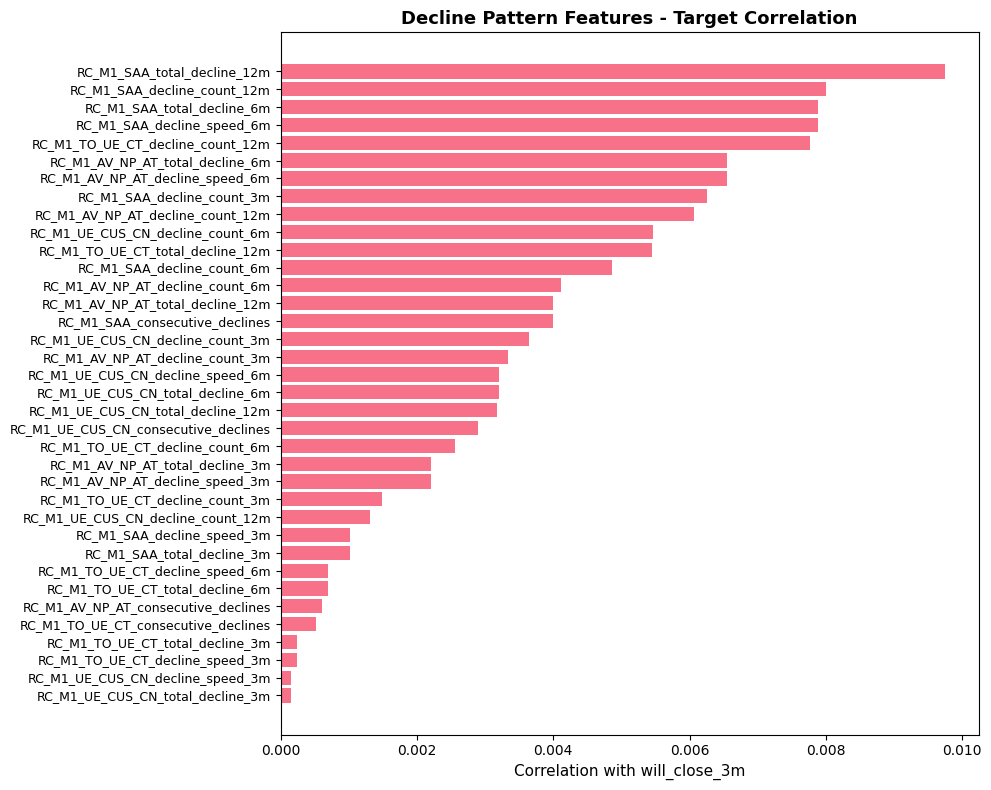

In [4]:
# 타겟 변수와의 상관관계 확인
valid_data = df[df['is_valid_for_training'] == 1].copy()

correlations = valid_data[decline_features].corrwith(valid_data['will_close_3m']).abs().sort_values(ascending=False)

print("\n연속 하락 패턴 features의 타겟 상관관계:")
print(correlations)

# 시각화
plt.figure(figsize=(10, 8))
plt.barh(range(len(correlations)), correlations.values)
plt.yticks(range(len(correlations)), [f[:50] for f in correlations.index], fontsize=9)
plt.xlabel('Correlation with will_close_3m', fontsize=11)
plt.title('Decline Pattern Features - Target Correlation', fontsize=13, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 4. 데이터 분할

In [5]:
# Valid training data만 사용
df_train = df[df['is_valid_for_training'] == 1].copy()

print(f"Valid training data: {len(df_train):,} rows")
print(f"Target distribution: {df_train['will_close_3m'].value_counts().to_dict()}")

Valid training data: 86,560 rows
Target distribution: {0: 86464, 1: 96}


In [6]:
# Train / Valid / Test split (시간 기반)
train_mask = df_train['TA_YM'] <= 202406
valid_mask = (df_train['TA_YM'] > 202406) & (df_train['TA_YM'] <= 202409)
test_mask = df_train['TA_YM'] > 202409

print("Data split:")
print(f"  Train: {train_mask.sum():,} rows (~ 202406)")
print(f"  Valid: {valid_mask.sum():,} rows (202407-202409)")
print(f"  Test:  {test_mask.sum():,} rows (202410+)")

Data split:
  Train: 62,257 rows (~ 202406)
  Valid: 11,933 rows (202407-202409)
  Test:  12,370 rows (202410+)


In [7]:
# Feature columns & Target
X_train = df_train[train_mask][decline_features]
y_train = df_train[train_mask]['will_close_3m']

X_valid = df_train[valid_mask][decline_features]
y_valid = df_train[valid_mask]['will_close_3m']

X_test = df_train[test_mask][decline_features]
y_test = df_train[test_mask]['will_close_3m']

print(f"\nFeature count: {len(decline_features)}")
print(f"\nTrain set target distribution:")
print(y_train.value_counts())
print(f"\nClass imbalance ratio: {(y_train == 0).sum() / (y_train == 1).sum():.1f}:1")


Feature count: 36

Train set target distribution:
will_close_3m
0    62183
1       74
Name: count, dtype: int64

Class imbalance ratio: 840.3:1


In [8]:
# 결측값 확인 및 처리
print("결측값 확인:")
print(f"  Train: {X_train.isnull().sum().sum()} nulls")
print(f"  Valid: {X_valid.isnull().sum().sum()} nulls")
print(f"  Test:  {X_test.isnull().sum().sum()} nulls")

# XGBoost는 결측값을 자동으로 처리하지만, 0으로 채우는 것도 옵션
# 여기서는 XGBoost의 자동 처리 활용 (별도 처리 안함)

결측값 확인:
  Train: 446020 nulls
  Valid: 18784 nulls
  Test:  18288 nulls


## 5. XGBoost 모델 학습

In [9]:
# Class imbalance 처리를 위한 scale_pos_weight 계산
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

print(f"Scale positive weight: {scale_pos_weight:.1f}")

Scale positive weight: 840.3


In [10]:
# XGBoost 모델 초기화
model = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,  # Class imbalance 처리
    max_depth=4,                         # 과적합 방지
    learning_rate=0.05,                  # 천천히 학습
    n_estimators=500,                    # 최대 반복
    early_stopping_rounds=50,            # 조기 종료
    eval_metric='aucpr',                 # PR-AUC 최적화
    random_state=42,
    tree_method='hist'                   # 빠른 학습
)

print("✅ XGBoost model initialized")
print(f"\nModel parameters:")
for key, value in model.get_params().items():
    if key in ['max_depth', 'learning_rate', 'n_estimators', 'scale_pos_weight', 'eval_metric']:
        print(f"  {key}: {value}")

✅ XGBoost model initialized

Model parameters:
  eval_metric: aucpr
  learning_rate: 0.05
  max_depth: 4
  n_estimators: 500
  scale_pos_weight: 840.3108108108108


In [11]:
# 모델 학습
print("Training XGBoost model...\n")

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    verbose=20
)

print("\n✅ Training completed!")

Training XGBoost model...

[0]	validation_0-aucpr:0.00622	validation_1-aucpr:0.00113
[20]	validation_0-aucpr:0.01413	validation_1-aucpr:0.00110
[40]	validation_0-aucpr:0.03130	validation_1-aucpr:0.00140
[60]	validation_0-aucpr:0.03395	validation_1-aucpr:0.00150
[80]	validation_0-aucpr:0.04020	validation_1-aucpr:0.00158
[100]	validation_0-aucpr:0.04974	validation_1-aucpr:0.00163
[120]	validation_0-aucpr:0.06109	validation_1-aucpr:0.00170
[140]	validation_0-aucpr:0.07732	validation_1-aucpr:0.00182
[160]	validation_0-aucpr:0.08850	validation_1-aucpr:0.00188
[180]	validation_0-aucpr:0.09998	validation_1-aucpr:0.00190
[200]	validation_0-aucpr:0.12038	validation_1-aucpr:0.00192
[220]	validation_0-aucpr:0.13482	validation_1-aucpr:0.00199
[240]	validation_0-aucpr:0.15056	validation_1-aucpr:0.00203
[260]	validation_0-aucpr:0.19510	validation_1-aucpr:0.00208
[280]	validation_0-aucpr:0.21373	validation_1-aucpr:0.00209
[300]	validation_0-aucpr:0.25841	validation_1-aucpr:0.00215
[320]	validation_0-

## 6. 모델 평가

In [12]:
# 예측
y_train_pred = model.predict(X_train)
y_train_proba = model.predict_proba(X_train)[:, 1]

y_valid_pred = model.predict(X_valid)
y_valid_proba = model.predict_proba(X_valid)[:, 1]

y_test_pred = model.predict(X_test)
y_test_proba = model.predict_proba(X_test)[:, 1]

print("✅ Predictions generated")

✅ Predictions generated


### 6.1 Train Set 평가

In [13]:
print("="*80)
print("Train Set Evaluation")
print("="*80)

# ROC-AUC
train_roc_auc = roc_auc_score(y_train, y_train_proba)
print(f"\nROC-AUC: {train_roc_auc:.4f}")

# PR-AUC
precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_proba)
train_pr_auc = auc(recall_train, precision_train)
print(f"PR-AUC: {train_pr_auc:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_train, y_train_pred))

# Confusion Matrix
cm_train = confusion_matrix(y_train, y_train_pred)
print("Confusion Matrix:")
print(cm_train)
print(f"\nTrue Positives: {cm_train[1,1]} / {(y_train == 1).sum()}")

Train Set Evaluation

ROC-AUC: 0.9632
PR-AUC: 0.3796

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.77      0.87     62183
           1       0.01      0.97      0.01        74

    accuracy                           0.77     62257
   macro avg       0.50      0.87      0.44     62257
weighted avg       1.00      0.77      0.87     62257

Confusion Matrix:
[[48100 14083]
 [    2    72]]

True Positives: 72 / 74


### 6.2 Validation Set 평가

In [14]:
print("="*80)
print("Validation Set Evaluation")
print("="*80)

# ROC-AUC
valid_roc_auc = roc_auc_score(y_valid, y_valid_proba)
print(f"\nROC-AUC: {valid_roc_auc:.4f}")

# PR-AUC
precision_valid, recall_valid, _ = precision_recall_curve(y_valid, y_valid_proba)
valid_pr_auc = auc(recall_valid, precision_valid)
print(f"PR-AUC: {valid_pr_auc:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_valid, y_valid_pred))

# Confusion Matrix
cm_valid = confusion_matrix(y_valid, y_valid_pred)
print("Confusion Matrix:")
print(cm_valid)
print(f"\nTrue Positives: {cm_valid[1,1]} / {(y_valid == 1).sum()}")
print(f"Detection Rate: {cm_valid[1,1] / (y_valid == 1).sum() * 100:.1f}%")

Validation Set Evaluation

ROC-AUC: 0.5989
PR-AUC: 0.0020

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.89      0.94     11922
           1       0.00      0.36      0.01        11

    accuracy                           0.89     11933
   macro avg       0.50      0.63      0.47     11933
weighted avg       1.00      0.89      0.94     11933

Confusion Matrix:
[[10619  1303]
 [    7     4]]

True Positives: 4 / 11
Detection Rate: 36.4%


### 6.3 Test Set 평가

In [15]:
print("="*80)
print("Test Set Evaluation")
print("="*80)

# ROC-AUC
test_roc_auc = roc_auc_score(y_test, y_test_proba)
print(f"\nROC-AUC: {test_roc_auc:.4f}")

# PR-AUC
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_proba)
test_pr_auc = auc(recall_test, precision_test)
print(f"PR-AUC: {test_pr_auc:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

# Confusion Matrix
cm_test = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(cm_test)
print(f"\nTrue Positives: {cm_test[1,1]} / {(y_test == 1).sum()}")
print(f"Detection Rate: {cm_test[1,1] / (y_test == 1).sum() * 100:.1f}%")

Test Set Evaluation

ROC-AUC: 0.6932
PR-AUC: 0.0018

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.89      0.94     12359
           1       0.00      0.27      0.00        11

    accuracy                           0.89     12370
   macro avg       0.50      0.58      0.47     12370
weighted avg       1.00      0.89      0.94     12370

Confusion Matrix:
[[11036  1323]
 [    8     3]]

True Positives: 3 / 11
Detection Rate: 27.3%


### 6.4 결과 요약

In [16]:
# 결과 요약 테이블
results_summary = pd.DataFrame({
    'Dataset': ['Train', 'Validation', 'Test'],
    'ROC-AUC': [train_roc_auc, valid_roc_auc, test_roc_auc],
    'PR-AUC': [train_pr_auc, valid_pr_auc, test_pr_auc],
    'True Positives': [cm_train[1,1], cm_valid[1,1], cm_test[1,1]],
    'Total Positives': [(y_train == 1).sum(), (y_valid == 1).sum(), (y_test == 1).sum()],
    'Detection Rate (%)': [
        cm_train[1,1] / (y_train == 1).sum() * 100,
        cm_valid[1,1] / (y_valid == 1).sum() * 100,
        cm_test[1,1] / (y_test == 1).sum() * 100
    ]
})

print("\n" + "="*80)
print("RESULTS SUMMARY - Decline Pattern Features Only")
print("="*80)
print(results_summary.to_string(index=False))
print("="*80)


RESULTS SUMMARY - Decline Pattern Features Only
   Dataset  ROC-AUC   PR-AUC  True Positives  Total Positives  Detection Rate (%)
     Train 0.963196 0.379561              72               74           97.297297
Validation 0.598935 0.002034               4               11           36.363636
      Test 0.693164 0.001785               3               11           27.272727


## 7. Feature Importance

In [17]:
# Feature importance
importance_df = pd.DataFrame({
    'feature': decline_features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance (연속 하락 패턴):")
print(importance_df.to_string(index=False))


Feature Importance (연속 하락 패턴):
                             feature  importance
          RC_M1_SAA_decline_count_3m    0.086634
    RC_M1_UE_CUS_CN_decline_count_6m    0.086389
    RC_M1_TO_UE_CT_decline_count_12m    0.057876
   RC_M1_UE_CUS_CN_decline_count_12m    0.054874
 RC_M1_TO_UE_CT_consecutive_declines    0.049353
    RC_M1_AV_NP_AT_total_decline_12m    0.048972
     RC_M1_AV_NP_AT_total_decline_6m    0.045926
     RC_M1_AV_NP_AT_decline_count_3m    0.040719
         RC_M1_SAA_total_decline_12m    0.037563
     RC_M1_AV_NP_AT_total_decline_3m    0.034154
         RC_M1_SAA_decline_count_12m    0.033889
    RC_M1_AV_NP_AT_decline_count_12m    0.032942
     RC_M1_TO_UE_CT_total_decline_3m    0.032004
     RC_M1_AV_NP_AT_decline_count_6m    0.029629
    RC_M1_UE_CUS_CN_total_decline_6m    0.029361
    RC_M1_UE_CUS_CN_decline_count_3m    0.028847
 RC_M1_AV_NP_AT_consecutive_declines    0.027432
          RC_M1_SAA_total_decline_6m    0.026725
     RC_M1_TO_UE_CT_decline_count_3m 

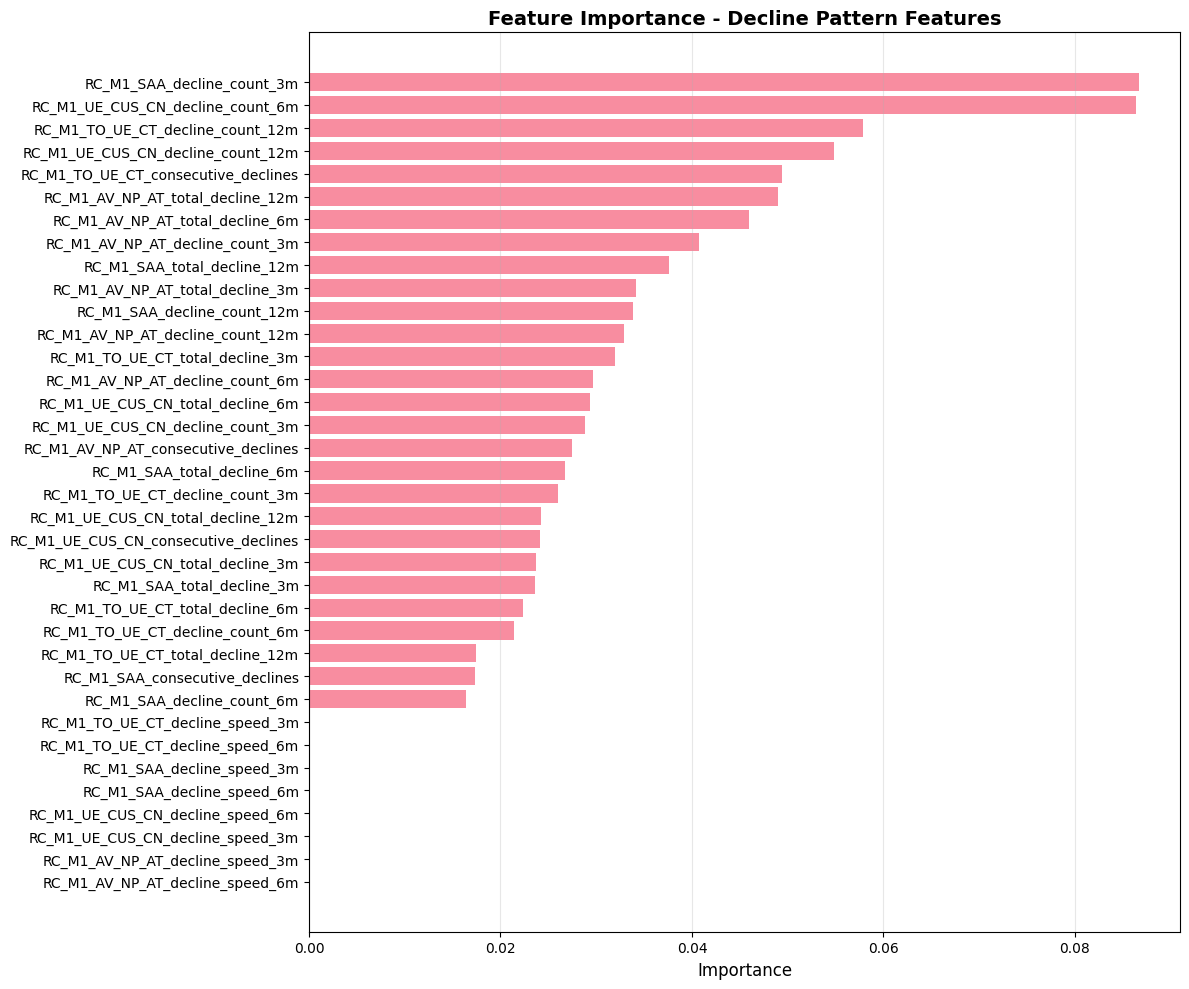

In [18]:
# Feature importance 시각화
fig, ax = plt.subplots(figsize=(12, 10))

ax.barh(range(len(importance_df)), importance_df['importance'].values, alpha=0.8)
ax.set_yticks(range(len(importance_df)))
ax.set_yticklabels([f[:60] for f in importance_df['feature'].values], fontsize=10)
ax.set_xlabel('Importance', fontsize=12)
ax.set_title('Feature Importance - Decline Pattern Features', fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Precision-Recall Curve

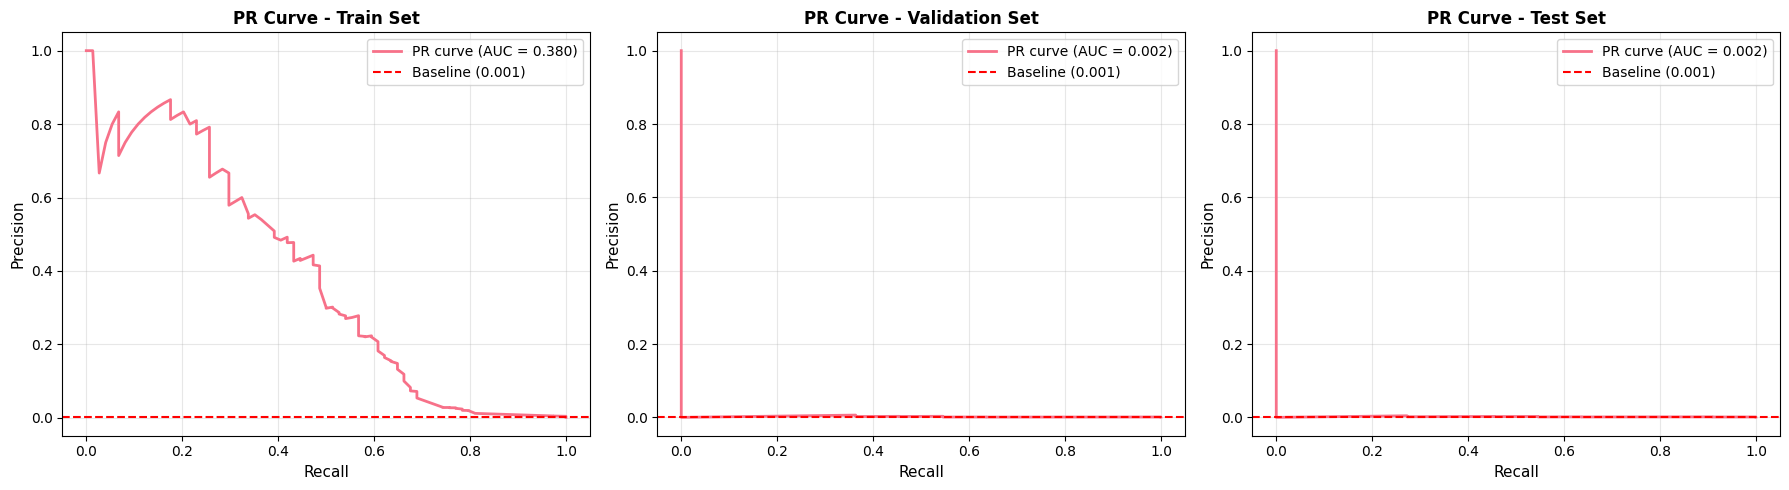

In [19]:
# PR Curve 시각화
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

datasets = [
    ('Train', y_train, y_train_proba, precision_train, recall_train, train_pr_auc),
    ('Validation', y_valid, y_valid_proba, precision_valid, recall_valid, valid_pr_auc),
    ('Test', y_test, y_test_proba, precision_test, recall_test, test_pr_auc)
]

for idx, (name, y_true, y_proba, precision, recall, pr_auc) in enumerate(datasets):
    ax = axes[idx]
    
    ax.plot(recall, precision, linewidth=2, label=f'PR curve (AUC = {pr_auc:.3f})')
    ax.axhline(y=(y_true == 1).sum() / len(y_true), color='red', linestyle='--', 
               label=f'Baseline ({(y_true == 1).sum() / len(y_true):.3f})')
    
    ax.set_xlabel('Recall', fontsize=11)
    ax.set_ylabel('Precision', fontsize=11)
    ax.set_title(f'PR Curve - {name} Set', fontsize=12, fontweight='bold')
    ax.legend(loc='best')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 9. 예측 확률 분포

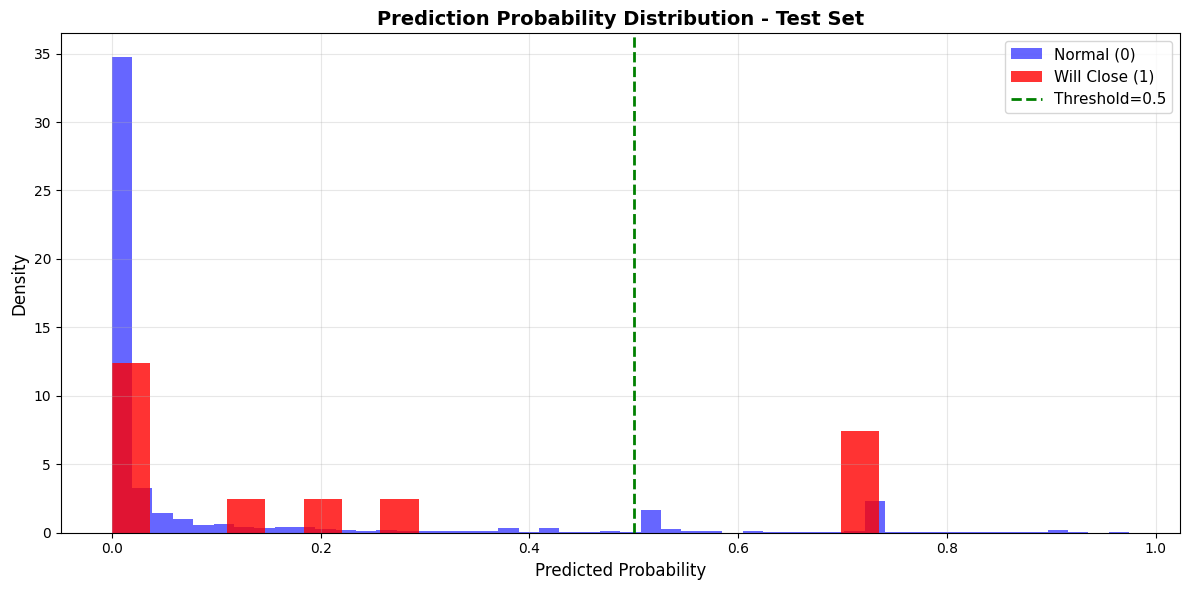

In [20]:
# Test set의 예측 확률 분포
fig, ax = plt.subplots(figsize=(12, 6))

# Class 0 (정상)
ax.hist(y_test_proba[y_test == 0], bins=50, alpha=0.6, label='Normal (0)', color='blue', density=True)

# Class 1 (폐업 예정)
ax.hist(y_test_proba[y_test == 1], bins=20, alpha=0.8, label='Will Close (1)', color='red', density=True)

ax.axvline(x=0.5, color='green', linestyle='--', linewidth=2, label='Threshold=0.5')
ax.set_xlabel('Predicted Probability', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Prediction Probability Distribution - Test Set', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 10. 결론

In [21]:
print("\n" + "="*80)
print("SIMPLE XGBOOST WITH DECLINE PATTERN FEATURES - FINAL REPORT")
print("="*80)

print(f"\n📊 Features Used: {len(decline_features)} decline pattern features")
print(f"\n🎯 Test Set Performance:")
print(f"   - ROC-AUC: {test_roc_auc:.4f}")
print(f"   - PR-AUC: {test_pr_auc:.4f}")
print(f"   - Detection Rate: {cm_test[1,1]}/{(y_test == 1).sum()} ({cm_test[1,1] / (y_test == 1).sum() * 100:.1f}%)")

print(f"\n🔝 Top 5 Important Features:")
for i, row in importance_df.head(5).iterrows():
    print(f"   {row['feature'][:70]}: {row['importance']:.4f}")

print(f"\n✅ Model saved to: ../models/xgboost_decline_only.json")
print("="*80)


SIMPLE XGBOOST WITH DECLINE PATTERN FEATURES - FINAL REPORT

📊 Features Used: 36 decline pattern features

🎯 Test Set Performance:
   - ROC-AUC: 0.6932
   - PR-AUC: 0.0018
   - Detection Rate: 3/11 (27.3%)

🔝 Top 5 Important Features:
   RC_M1_SAA_decline_count_3m: 0.0866
   RC_M1_UE_CUS_CN_decline_count_6m: 0.0864
   RC_M1_TO_UE_CT_decline_count_12m: 0.0579
   RC_M1_UE_CUS_CN_decline_count_12m: 0.0549
   RC_M1_TO_UE_CT_consecutive_declines: 0.0494

✅ Model saved to: ../models/xgboost_decline_only.json


## 11. 모델 저장

In [22]:
# 모델 저장
import json
from pathlib import Path

models_dir = Path('../models')
models_dir.mkdir(exist_ok=True)

# XGBoost 모델 저장
model.save_model(str(models_dir / 'xgboost_decline_only.json'))

# Feature 정보 저장
model_info = {
    'model_type': 'XGBoost',
    'features': decline_features,
    'feature_count': len(decline_features),
    'test_roc_auc': float(test_roc_auc),
    'test_pr_auc': float(test_pr_auc),
    'test_detection_rate': float(cm_test[1,1] / (y_test == 1).sum()),
    'feature_importance': importance_df.to_dict('records')
}

with open(models_dir / 'xgboost_decline_only_info.json', 'w') as f:
    json.dump(model_info, f, indent=2)

print("✅ Model and info saved successfully!")

✅ Model and info saved successfully!
